In [1]:
#copying and adapting code from https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=YyQtV7155Nht

In [3]:
#apply to 2D example
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import pandas as pd
import math

#import models
from models import ScoreNet_2D
from training import loss_fn

#import SDE functions
from SDE import marginal_prob_std_fn_2D as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_2D as diffusion_coeff_fn

#import sampling functions
from sampling import Euler_Maruyama_sampler_2D, pc_sampler_2D, ode_sampler_2D

# Define model

In [4]:
score_model = ScoreNet_2D(marginal_prob_std=marginal_prob_std_fn)

In [3]:
sum(p.numel() for p in score_model.parameters())

32210

# Training

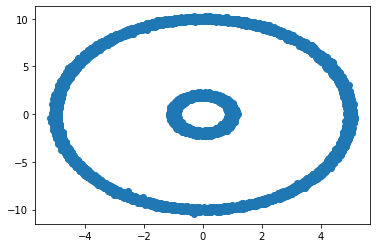

In [23]:
circles, _ = datasets.make_circles(50000, noise=0.01, factor=0.2, shuffle=True)
circles = circles* [5., 10.] 
circles = circles.T
plt.scatter(circles[0], circles[1])

In [24]:
epochs = 100
batch_size = 128
lr=1e-4

score_model = ScoreNet_2D(marginal_prob_std=marginal_prob_std_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = torch.tensor(circles).T
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        #print(x)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'models/circles.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

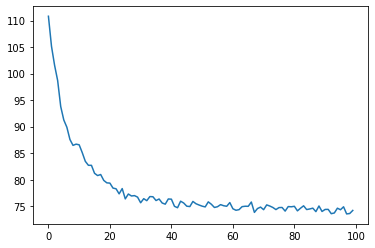

In [25]:
plt.plot(losses)

# Draw samples

In [26]:
device = 'cpu' 
ckpt = torch.load('models/circles.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 

pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of function evaluations: 278


  0%|          | 0/1000 [00:00<?, ?it/s]

(-11.0, 11.0)

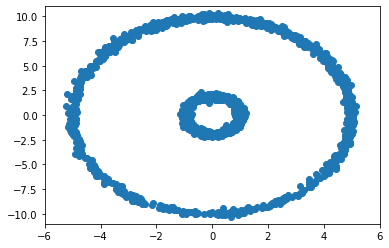

In [33]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])
plt.xlim(-6,6)
plt.ylim(-11,11)

(-11.0, 11.0)

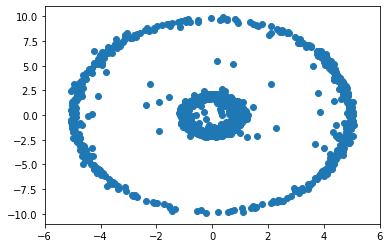

In [32]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])
plt.xlim(-6,6)
plt.ylim(-11,11)

(-11.0, 11.0)

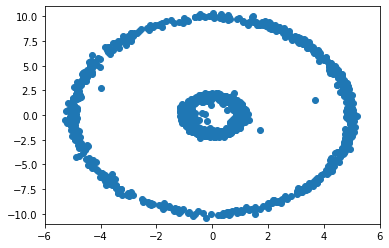

In [31]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])
plt.xlim(-6,6)
plt.ylim(-11,11)

(-11.0, 11.0)

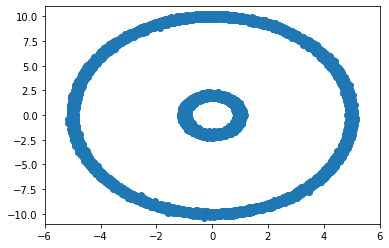

In [30]:
plt.scatter(circles[0], circles[1])
plt.xlim(-6,6)
plt.ylim(-11,11)

In [206]:
#Now trying with conditional dataset

In [12]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

In [13]:
y = -6 * torch.rand(50000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 50000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

In [14]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

In [22]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_1_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


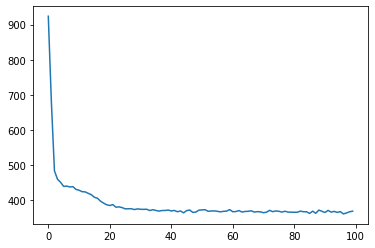

In [23]:
plt.plot(losses)

In [35]:
ckpt = torch.load('models/ex_1_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 

pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of function evaluations: 212


  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

(-3.2, 3.2)

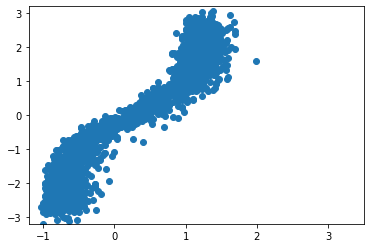

In [36]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

(-3.2, 3.2)

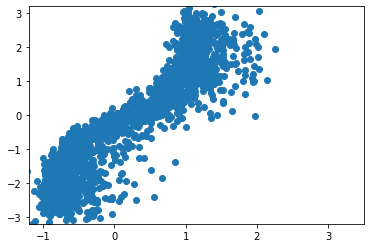

In [37]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

(-3.2, 3.2)

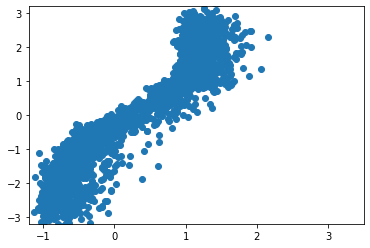

In [38]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

In [20]:
indices = torch.randperm(len(ex_1))[:2048]

(-3.2, 3.2)

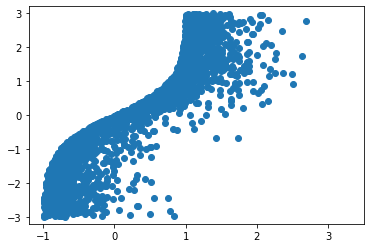

In [21]:
plt.scatter(ex_1[indices][:,0], ex_1[indices][:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

In [35]:
#@title Define the likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=1) / (2 * sigma**2)

def ode_likelihood(x, 
                   score_model,
                   marginal_prob_std, 
                   diffusion_coeff,
                   batch_size=64, 
                   device='cpu',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.
  
  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the 
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the 
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    score_sample = torch.hstack([sample, time_steps])
    with torch.enable_grad():
      score_sample.requires_grad_(True)
      score_e = torch.sum(score_model(score_sample) * epsilon)
        
      grad_score_e = torch.autograd.grad(score_e, score_sample)[0]
    
    grad_score_e = grad_score_e[:,[0,1]]

    return torch.sum(grad_score_e * epsilon, dim=1)    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], 1))   
    sample = torch.hstack([sample, time_steps])
    with torch.no_grad():    
      score = score_model(sample)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], 1))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [37]:
#@title Compute likelihood on the dataset (double click to expand or collapse)
#NOT SURE IF THIS IS WORKING

batch_size = 1000 #@param {'type':'integer'}

dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size)

ckpt = torch.load('models/ex_1_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = notebook.tqdm(data_loader)
  for x in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    #x = (x * 255. + torch.rand_like(x)) / 256.    
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [168]:
all_bpds / all_items
#is this unit applicable? bits/dim used for image likelihood. Doubt its the same for datapoints

tensor(9.2757, dtype=torch.float64)

In [38]:
#training ex_2
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_2_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


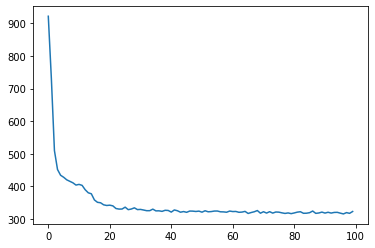

In [39]:
#323
plt.plot(losses)

In [39]:
device = 'cpu' 
ckpt = torch.load('models/ex_2.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 

pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of function evaluations: 212


  0%|          | 0/1000 [00:00<?, ?it/s]

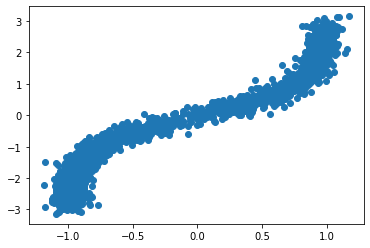

In [40]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

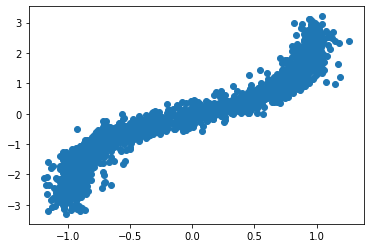

In [41]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])

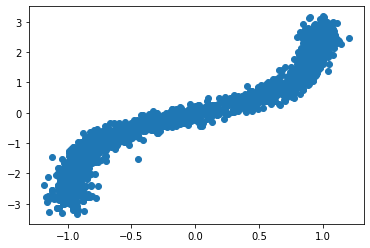

In [42]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])

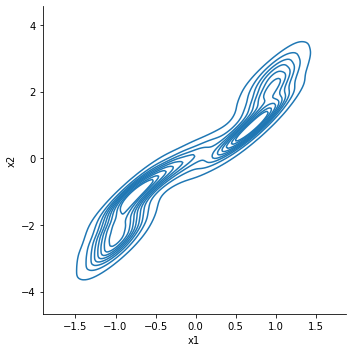

In [45]:
density_plot(pc_samples)

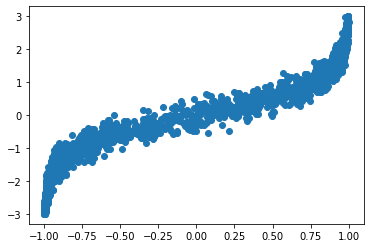

In [46]:
plt.scatter(ex_2[indices][:,0], ex_2[indices][:,1])

In [47]:
#training ex_3
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_3_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


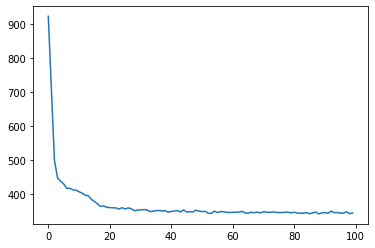

In [48]:
#351
plt.plot(losses)

In [43]:
device = 'cpu' 
ckpt = torch.load('models/ex_3.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 


pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of function evaluations: 218


  0%|          | 0/1000 [00:00<?, ?it/s]

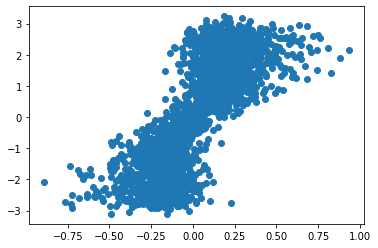

In [44]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

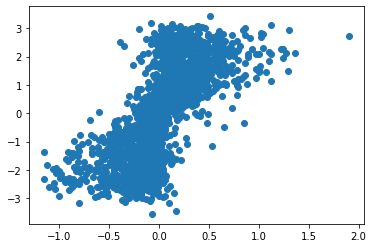

In [45]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])

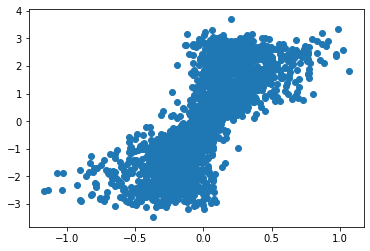

In [46]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])

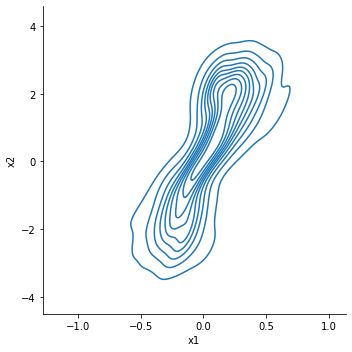

In [53]:
density_plot(pc_samples)

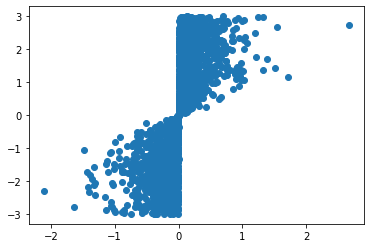

In [54]:
plt.scatter(ex_3[indices][:,0], ex_3[indices][:,1])